<a href="https://colab.research.google.com/github/shraddha1803/comp_stats_project2/blob/main/Assignment_3_EVALUATION_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📡 Introduction to Retrieval Augmented Generation using Knowledge Graphs


The **Retrieval Augmented Generation** (RAG) approach involves dynamically retrieving relevant information from a knowledge base to assist in the generation of responses or predictions.

In our case, RAG enables to combine structured knowledge from knowledge graphs (KG) with Large Language Models(LLM) natural language capabilities.

By default LLMs are 1. a natural language interface with machines; 2. a knowledge base (their training data). But a LLM knowledge base is opaque and not consistent, as the knowledge generated is probabilistic and highly depends on the input ton, it can output contradictory knowledge.

With RAG we can reduce the incertainty related to the LLM black-box knowledge base, by plugin an external trusted knowledge base. And using the LLM as a natural language interface to our own data.

But it is still a **really new field**. The 2 main approaches currently used are:

1. Just vectorize the KG to provide better context to the LLM. Easiest approach (classic RAG):
    1. You iterate a KG, generate text embeddings for each concepts (various strategies possible here: text embeddings, GNN...) and store them in a vector database.
    2. When a user ask a question to the LLM, you ask the LLM to reformulate the question to make it straight to the point, so the search for relevant concepts in your vector db is more efficient
    3. You generate embeddings for this question, and search for the most similar concepts in the vector database
    4. You provide the informations about those concepts to the LLM as context, now asking it to answer the question using the provided context.

    Its efficiency will depend a lot on the strategy adopted to generate embeddings (do you just use the concepts description? Do you include the links between concepts? How?)

2. Use the LLM to generate queries for your KG
    1. Get the "schema" of the queried KG (e.g. OWL ontology, SHACL shapes, VoID description)
    2. Provide the KG schema as input to the LLM
    3. Ask the LLM to generate a query to answer your question
    4. Execute the query


## 🎯 Aim

This notebook present a demo of **Retrieval Augmented Generation** (RAG) to faithfully resolve and use concepts from an OWL ontology, with conversation memory, using open source components:
* [LangChain](https://python.langchain.com) (cf. docs: [RAG with memory](https://python.langchain.com/docs/expression_language/cookbook/retrieval), [streaming RAG](https://python.langchain.com/docs/use_cases/question_answering/streaming))
* [FastEmbed embeddings](https://github.com/qdrant/fastembed)
* [Qdrant vectorstore](https://github.com/qdrant/qdrant)

You can easily change the different components used in this workflow to use whatever you prefer thanks to LangChain:
* LLM (e.g. switch to Mistral, and that's it. Every other LLMs are not available in Europe)
* Vectorstore (e.g. switch to [FAISS](https://python.langchain.com/docs/integrations/vectorstores/faiss), [Chroma](https://python.langchain.com/docs/integrations/vectorstores/chroma), Milvus)
* Embedding model (e.g. switch to [HuggingFace sentence transformer](https://python.langchain.com/docs/integrations/text_embedding/sentence_transformers), OpenAI ADA)

## 🔗 Relevant resources

Programming frameworks:

* [LangChain](https://github.com/langchain-ai/langchain): build linear workflows for LLM
* [LangGraph](https://github.com/langchain-ai/langgraph): build circular workflows for LLM, with control loop
* [LlamaIndex](): framework to help build RAG systems (a lot of noise around it, but they use global static variables for configuration in their top examples, which is highly concerning for the rest of the code. What if I want to deploy 2 indexes with different config? I can't.)

Most existing research for TRAG+KG are using property grap[hs like neo4j or nebula graph (the tooling to work with RDF graphs is too bad):
* [KG-RAG](https://github.com/BaranziniLab/KG_RAG): integrate ad-hoc KG data to LLM answers.
    1. ask the LLM to extract disease entities from the question
    2. query the KG to retrieve the context related to the extracted entities
    3. feed the retrieved context to the LLM
* [Graph-LLM](https://github.com/CurryTang/Graph-LLM): Paper and code about "Exploring the Potential of Large Language Models (LLMs) in Learning on Graphs ". Basically LLM + GNN using PyTorch Geometric (PyG). They use LLM to increase the informations used to build the GNN.


## Questions

Your LLM should answer those 2 follow-up questions using the [SemanticScience OWL ontology](https://github.com/MaastrichtU-IDS/semanticscience):

- "What is a protein?"
- "What is the URI for this concept?"

## 📦️ Install and import dependencies

Get your OpenAI API key


In [1]:
import sys
!{sys.executable} -m pip install -q langchain langchain-community langchain-openai fastembed qdrant-client oxrdflib

from operator import itemgetter
import getpass
import os

from langchain.globals import set_debug
from langchain.memory import ConversationBufferMemory
from langchain.prompts import ChatPromptTemplate
from langchain.prompts.prompt import PromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import format_document
from langchain_openai import OpenAI
from langchain_community.vectorstores import Qdrant
from langchain_community.embeddings.fastembed import FastEmbedEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import get_buffer_string
from langchain_core.runnables import RunnableLambda, RunnablePassthrough

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Provide your OpenAI API Key")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 810.5/810.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.6/271.6 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.9/262.9 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 66.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

## ⚗️ Define how to extract infos to embed from the ontology

We will extend the LangChain document loader class to create a loader for OWL ontologies

**TODO**: you will need to write the SPARQL query to extract the concepts (classes and properties) labels and descriptions from the ontology.

The current loader code expect your query to return the variables below.
- `?uri` of the concept
- `?label` containing the human readable label or description of this concept
- `?predicate` defining the retrieved label (e.g. rdfs:label, rdfs:comment, dcterms:description)
- `?type` of the concept (e.g. owl:Class or property)

Feel free to add more variables! You will just need to add 1 line to the code below to add this variable as concept metadata in the vectorstore

In [2]:
from typing import Any, List, Optional

from langchain_community.document_loaders.base import BaseLoader
from langchain_core.documents import Document
from rdflib import Graph, URIRef

# SPARQL query to retrieve labels, descriptions, and additional metadata of classes and properties
extract_classes_query = """


PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX oboInOwl: <http://www.geneontology.org/formats/oboInOwl#>

SELECT ?uri ?label ?type ?predicate ?ontology ?value ?synonym ?subclassOf
WHERE {
  ?uri rdf:type owl:Class ;
       rdfs:label ?label .

  OPTIONAL {?uri a ?type .}
  OPTIONAL { ?uri oboInOwl:hasExactSynonym ?synonym . }
  OPTIONAL { ?uri rdfs:subClassOf ?subclassOf}

  OPTIONAL {
    ?uri ?predicate ?value .
    FILTER(?predicate = obo:IAO_0000115)
  }

  BIND("disease_ontology" AS ?ontology)

}

"""

class OntologyLoader(BaseLoader):
    """Load an OWL ontology and extract classes and properties as documents."""

    def __init__(self, ontology_url: str, format: Optional[str] = None):
        self.ontology_url = ontology_url
        self.format = format
        self.graph = Graph(store="Oxigraph")
        self.graph.parse(self.ontology_url, format=self.format)
        print(f"Working with {len(self.graph)} triples")

    def load(self) -> List[Document]:
        """Load and return documents (classes and properties) from the OWL ontology."""
        docs: List[Document] = []
        for result in self.graph.query(extract_classes_query):
            docs.append(self._create_document(result))
        return docs

    def _create_document(self, result_row: Any) -> Document:
        """Create a Document object from a query result row."""
        label = str(result_row.label)
        return Document(
            page_content=label,
            # NOTE: you can include more metadata retrieved by the SPARQL query here
            metadata={
                "label": label,
                "uri": str(result_row.uri),
                "type": str(result_row.type),
                "predicate": str(result_row.predicate),
                "ontology": self.ontology_url,
                "synonym": str(result_row.synonym),
                "subclassOf": str(result_row.subclassOf),
            },
        )

## 🌀 Initialize local vectorstore and LLM

Use the ontology loader we just created, with the embedding model we chose.

In [3]:
flag_embeddings = FastEmbedEmbeddings(model_name="BAAI/bge-small-en-v1.5", max_length=512)
loader = OntologyLoader("https://raw.githubusercontent.com/DiseaseOntology/HumanDiseaseOntology/main/src/ontology/subsets/DO_cancer_slim.owl", format="xml")
docs = loader.load()

# Split the documents into chunks if necessary
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
vectorstore = Qdrant.from_documents(
    splits,
    flag_embeddings,
    collection_name="ontologies",
    location=":memory:",
    # path="./data/qdrant",
)
# vectorstore = FAISS.from_documents(documents=docs, embedding=flag_embeddings)
# K is the number of source documents retrieved
retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

llm = OpenAI(temperature=0)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

ort_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model_optimized.onnx:   0%|          | 0.00/66.5M [00:00<?, ?B/s]

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py", line 658, in can_be_executed_by
    frame = None
RuntimeError: pyoxigraph::store::QuadIter is unsendbale, but is dropped on another thread!


Working with 14210 triples


 ## 🔬 Evaluation


In [4]:
import pandas as pd
# Load the graph
format="xml"
ontology_url = "https://raw.githubusercontent.com/DiseaseOntology/HumanDiseaseOntology/main/src/ontology/subsets/DO_cancer_slim.owl"
graph = Graph(store="Oxigraph")
graph.parse(ontology_url, format=format)

<Graph identifier=N5f0f1911c3964522ae1f2c4de6a5f7d7 (<class 'rdflib.graph.Graph'>)>

Same but no memory and reformulate prompt:

In [5]:
from langchain.chains import LLMChain

DEFAULT_DOCUMENT_PROMPT = PromptTemplate.from_template(
    template="Concept label: {page_content} | URI: {uri} | Type: {type} | Predicate: {predicate} | Ontology: {ontology}"
)

answer_template = """Briefly answer the question based only on the following context,
do not use any information outside this context:
{context}

Question: {question}
"""
ANSWER_PROMPT = ChatPromptTemplate.from_template(answer_template)

def _combine_documents(
    docs, document_prompt=DEFAULT_DOCUMENT_PROMPT, document_separator="\n\n"
):
    doc_strings = [format_document(doc, document_prompt) for doc in docs]
    # print("Formatted docs:", doc_strings)
    return document_separator.join(doc_strings)

# Simplified approach without LLM memory and reformulation
def run_chain(question: str, retriever) -> dict[str, Any]:

    # Directly retrieve documents based on the original question
    retrieved_docs = retriever.get_relevant_documents(question, search_kwargs={"k": 5})
    context = _combine_documents(retrieved_docs)

    # Use the combined context to generate an answer
    llm_chain = LLMChain(prompt=ANSWER_PROMPT, llm=llm)
    answer = llm_chain.run(context=context, question=question)

    # Return the constructed answer along with the source documents
    return {"answer": answer, "docs": [doc.dict() for doc in retrieved_docs]}



#### DEFINITIONS


In [6]:
##a query to retrieve the definition of the classes
query = """
        PREFIX obo: <http://purl.obolibrary.org/obo/>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        SELECT ?label  ?definition
        WHERE {
            ?entity a owl:Class  .
            ?entity rdfs:label ?label .
            ?entity obo:IAO_0000115 ?definition .
        }LIMIT 30
        """


definitions = []
for row in graph.query(query):
    definitions.append(row)
df = pd.DataFrame(definitions, columns=["label", "definition"])
df.head()

,label,definition
0,atypical teratoid rhabdoid tumor,A brain cancer that is usually located in the ...
1,follicular lymphoma,A B-cell lymphoma that is characterized as an ...
2,fibrolamellar carcinoma,A hepatocellular carcinoma characterized micro...
3,IDH-wildtype anaplastic astrocytoma,An anaplastic astrocytoma lacking mutations in...
4,B-lymphoblastic leukemia/lymphoma with hypodip...,A B-lymphoblastic leukemia/lymphoma that is co...


In [15]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

unique_labels = df["label"].unique()[:100]
data = []

for label in unique_labels:
    llm_definition = run_chain(f"What is the definition of {label}?",retriever)
    llm_definition = llm_definition["answer"]
    ont_definition = df[df["label"] == label]["definition"].values.item()

    # Vectorize text using TF-IDF
    vectorizer = TfidfVectorizer()
    vectorizer.fit([llm_definition, ont_definition])
    ontology_vector = vectorizer.transform([ont_definition])
    llm_output_vector = vectorizer.transform([llm_definition])

    # Calculate cosine similarity
    similarity_score = cosine_similarity(ontology_vector, llm_output_vector)[0][0]

    # Append the details to the list
    data.append({
        "Label": label,
        "LLM Definition": llm_definition,
        "Ontology Definition": ont_definition,
        "Cosine Similarity": similarity_score
    })

definitions_df = pd.DataFrame(data)
average_similarity = definitions_df["Cosine Similarity"].mean()
print("Average Cosine Similarity:", average_similarity)
definitions_df.head()


Average Cosine Similarity: 0.3008951006031877


,Label,LLM Definition,Ontology Definition,Cosine Similarity
0,atypical teratoid rhabdoid tumor,\nAnswer: Atypical teratoid rhabdoid tumor is ...,A brain cancer that is usually located in the ...,0.297234
1,follicular lymphoma,\nFollicular lymphoma is a type of B-cell lymp...,A B-cell lymphoma that is characterized as an ...,0.165240
2,fibrolamellar carcinoma,\nAnswer: Fibrolamellar carcinoma is a type of...,A hepatocellular carcinoma characterized micro...,0.114643
3,IDH-wildtype anaplastic astrocytoma,\nAnswer: IDH-wildtype anaplastic astrocytoma ...,An anaplastic astrocytoma lacking mutations in...,0.233633
4,B-lymphoblastic leukemia/lymphoma with hypodip...,\nAnswer: B-lymphoblastic leukemia/lymphoma wi...,A B-lymphoblastic leukemia/lymphoma that is co...,0.336880


In [8]:
!pip install matplotlib
import matplotlib.pyplot as plt

PLOTTING THE DISTRIBUTION

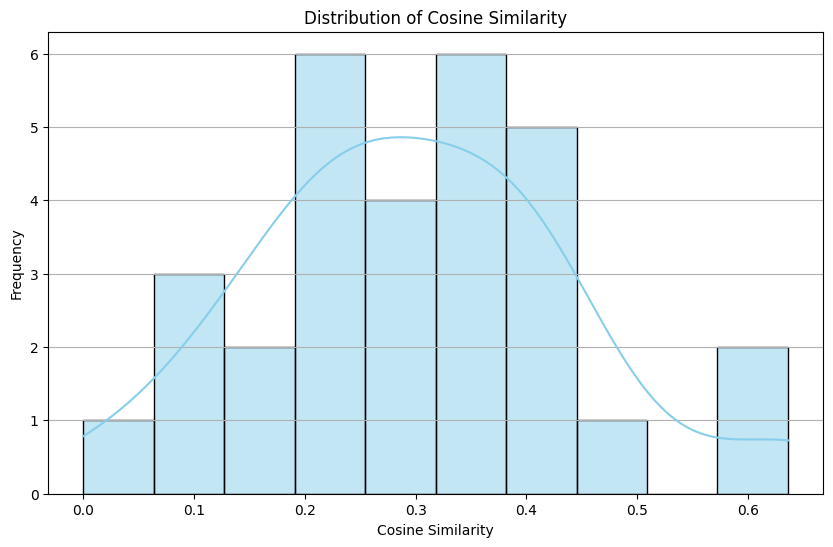

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Select only a few unique labels for demonstration
unique_labels = df["label"].unique()[:100]

similarity_scores = []
for label in unique_labels:
    llm_definitions = run_chain(f"What is the definition of '{label}' ? ", retriever)
    llm_definitions = llm_definitions["answer"]
    ont_definitions = df[df["label"] == label]["definition"].values
    ont_definitions = [definition.value for definition in ont_definitions]
    ont_definitions = ", ".join(ont_definitions)

    # Vectorize text using TF-IDF
    vectorizer = TfidfVectorizer()
    vectorizer.fit([ont_definitions, llm_definitions])
    ontology_vector = vectorizer.transform([ont_definitions])
    llm_output_vector = vectorizer.transform([llm_definitions])

    # Calculate cosine similarity
    similarity_score = cosine_similarity(ontology_vector, llm_output_vector)[0][0]
    similarity_scores.append(similarity_score)

# Plotting histogram and KDE
plt.figure(figsize=(10, 6))
sns.histplot(similarity_scores, bins=10, kde=True, color='skyblue')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Cosine Similarity')
plt.grid(axis='y')
plt.show()

In [12]:
from scipy import stats
!pip install numpy
import numpy as np

Kolmogorov-Smirnov Test:
Statistic: 0.3827775205165831
P-value: 0.0001833328436985429
Null hypothesis (data follows a normal distribution) is rejected.


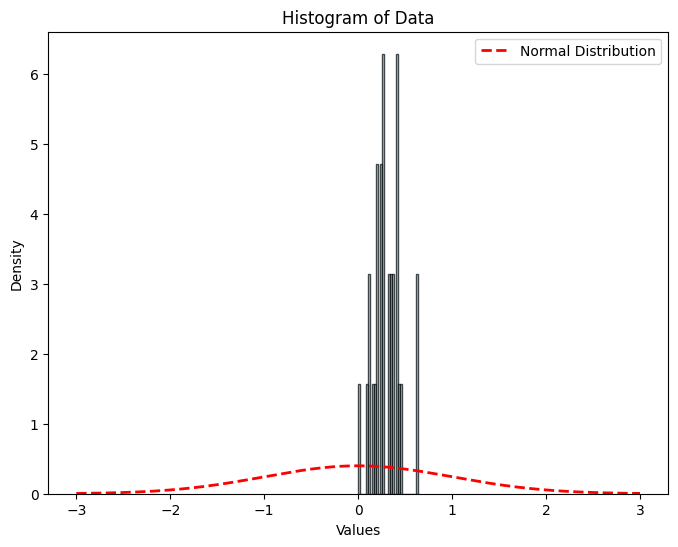

In [21]:
import numpy as np
from scipy.stats import kstest, norm  # Import norm function here
import matplotlib.pyplot as plt

lam = np.mean(similarity_scores)

# Perform the Kolmogorov-Smirnov test
test_statistic, p_value = stats.kstest(similarity_scores, 'norm', args=(lam,))

print("Kolmogorov-Smirnov Test:")
print(f"Statistic: {test_statistic}")
print(f"P-value: {p_value}")

# Define significance level
alpha = 0.05

# Compare p-value with significance level
if p_value > alpha:
    print("Null hypothesis (data follows a normal distribution) cannot be rejected.")
else:
    print("Null hypothesis (data follows a normal distribution) is rejected.")

# Plot the histogram of data
plt.figure(figsize=(8, 6))
plt.hist(similarity_scores, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')

# Overlay a theoretical normal distribution
x = np.linspace(-3, 3, 1000)
y = norm.pdf(x, loc=0, scale=1)
plt.plot(x, y, color='red', linestyle='--', linewidth=2, label='Normal Distribution')

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Histogram of Data')

# Add legend
plt.legend()

# Show plot
plt.show()

#### SYNONYMS


In [ ]:
# Extract synonyms of classes from the ontology
synonyms_query = """

PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX oboInOwl: <http://www.geneontology.org/formats/oboInOwl#>

SELECT ?label ?synonym ?parentlabel
WHERE {
  ?class rdfs:label ?label .
  ?class oboInOwl:hasExactSynonym ?synonym .
  ?class rdfs:subClassOf ?subclassOf.
  ?subclassOf rdfs:label ?parentlabel.
}
"""


synonyms = []
for row in graph.query(synonyms_query):
    synonyms.append(row)

# conver to pandas dataframe

df = pd.DataFrame(synonyms, columns=["label", "synonym","parent"])
df.head()

,label,synonym,parent
0,B-cell lymphoma,B-cell lymphocytic neoplasm,non-Hodgkin lymphoma
1,Cowden syndrome,Cowden disease,PTEN hamartoma tumor syndrome
2,Cowden syndrome,Lhermitte-Duclos disease,PTEN hamartoma tumor syndrome
3,Cowden syndrome,dysplastic Gangliocytoma of Cerebellum,PTEN hamartoma tumor syndrome
4,Ewing sarcoma,Ewing's tumor,cancer


In [ ]:

data = []
for label in unique_labels:

    llm_synonyms = run_chain(f"List the synonyms for '{label}' in a comma-separated format as follows: synonym1, synonym2, ...",retriever)
    llm_synonyms = llm_synonyms["answer"]
    ont_synonyms = df[df["label"] == label]["synonym"].values
    ont_synonyms = [synonym.value for synonym in ont_synonyms]
    ont_synonyms = ", ".join(ont_synonyms)


    # Vectorize text using TF-IDF
    vectorizer = TfidfVectorizer()
    vectorizer.fit([ont_synonyms, llm_synonyms])
    ontology_vector = vectorizer.transform([ont_synonyms])
    llm_output_vector = vectorizer.transform([llm_synonyms])
    # Calculate cosine similarity
    similarity_score = cosine_similarity(ontology_vector, llm_output_vector)[0][0]
    # Append the details to the list
    data.append({
        "Label": label,
        "LLM Synonyms": llm_synonyms,
        "Ontology Synonyms": ont_synonyms,
        "Cosine Similarity": similarity_score
    })

synonyms_df = pd.DataFrame(data)
average_similarity = synonyms_df["Cosine Similarity"].mean()
print("Average Cosine Similarity:", average_similarity)
synonyms_df.head()


Average Cosine Similarity: 0.3037352370532397


,Label,LLM Synonyms,Ontology Synonyms,Cosine Similarity
0,atypical teratoid rhabdoid tumor,"\nATRT, AT/RT, atypical teratoid/rhabdoid tumo...","Atypical teratoid/rhabdoid tumour, atypical te...",0.782597
1,follicular lymphoma,"\nSynonyms: FL, follicular lymphosarcoma, foll...",,0.000000
2,fibrolamellar carcinoma,\nSynonyms: fibrolamellar hepatocellular carci...,"Oncocytic Hepatocellular tumor, Hepatocellular...",0.576598
3,IDH-wildtype anaplastic astrocytoma,"\nIDH-wildtype glioblastoma, IDH-mutant anapla...",,0.000000
4,B-lymphoblastic leukemia/lymphoma with hypodip...,"\nB-ALL with hypodiploidy, B-cell acute lympho...",B-ALL with hypodiploidy,0.751222


#### SUBCLASS OF

In [ ]:
data = []
for label in unique_labels:

    llm_parent = run_chain(f"What is the parent class of '{label}'?",retriever)
    llm_parent = llm_parent["answer"]
    llm_parent = llm_parent.split()[-1] if llm_parent else ''

    ont_parent = df[df["label"] == label]["parent"].values
    ont_parent = [synonym.value for synonym in ont_parent]
    ont_parent = ", ".join(ont_parent)

    print("Ontology parent:", ont_parent)
    print("LLM parent:", llm_parent)

    # Vectorize text using TF-IDF
    vectorizer = TfidfVectorizer()
    vectorizer.fit([ont_parent, llm_parent])
    ontology_vector = vectorizer.transform([ont_parent])
    llm_output_vector = vectorizer.transform([llm_parent])
    # Calculate cosine similarity
    similarity_score = cosine_similarity(ontology_vector, llm_output_vector)[0][0]
    data.append({
        "Label": label,
        "LLM parent": llm_synonyms,
        "Ontology parent": ont_synonyms,
        "Cosine Similarity": similarity_score
    })

parent_df = pd.DataFrame(data)
average_similarity = parent_df["Cosine Similarity"].mean()
print("Average Cosine Similarity:", average_similarity)
parent_df.head()

Ontology parent: B-cell lymphocytic neoplasm
LLM parent: leukemia/lymphoma'.
Cosine Similarity: 0.0
Ontology parent: Cowden disease, Lhermitte-Duclos disease, dysplastic Gangliocytoma of Cerebellum
LLM parent: context.
Cosine Similarity: 0.0
Ontology parent: Ewing's tumor, Ewings sarcoma, PNET of Thoracopulmonary Region, Ewing's sarcoma/peripheral primitive neuroectodermal tumor, localized Ewing's sarcoma, peripheral primitive neuroectodermal tumor, Ewing's family localized tumor, localized Ewing sarcoma, localized Ewing's sarcoma/peripheral primitive neuroectodermal tumor, localized peripheral primitive neuroectodermal tumor, Ewings sarcoma-primitive neuroectodermal tumor, localized Ewing's tumor
LLM parent: cancer.
Cosine Similarity: 0.0
Ontology parent: Pacinian neurofibroma
LLM parent: tumor'.
Cosine Similarity: 0.0
Ontology parent: Stem cell Leukemia, Stem cell leukaemia
LLM parent: leukemia'.
Cosine Similarity: 0.23076792961123066
Ontology parent: mullerian Adenosarcoma
LLM paren